In [195]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from sklearn.metrics import confusion_matrix
from pyspark.sql.functions import when
import pandas as pd
from dtreeviz.models.spark_decision_tree import ShadowSparkTree
from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType
from pyspark.ml.feature import StringIndexer
from sklearn.metrics import ConfusionMatrixDisplay
import traceback
import logging
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.tree import _tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.tree import _tree
import numpy as np
from pyspark.ml import Pipeline

In [196]:
config = SparkConf()
spark = SparkSession.builder.master("local").appName("test").config(conf=config).getOrCreate()

In [197]:
# Preparing the train
train = spark.read.option("header", "true").csv(r"data\train.csv")
# filtre et supprime les données "NA"
train = train.filter(train.Age != "NA")
train = train.withColumn("Gender", when(train.Sex == "male","1").when(train.Sex == "female","2"))
# Supprime les colonnes inutiles
cols = ('SibSp', 'Parch', 'Fare', 'Ticket' ,'Cabin', 'Embarked', 'Name', 'Sex')
train = train.drop(*cols)

train.show(10)

+-----------+--------+------+---+------+
|PassengerId|Survived|Pclass|Age|Gender|
+-----------+--------+------+---+------+
|          1|       0|     3| 22|     1|
|          2|       1|     1| 38|     2|
|          3|       1|     3| 26|     2|
|          4|       1|     1| 35|     2|
|          5|       0|     3| 35|     1|
|          7|       0|     1| 54|     1|
|          8|       0|     3|  2|     1|
|          9|       1|     3| 27|     2|
|         10|       1|     2| 14|     2|
|         11|       1|     3|  4|     2|
+-----------+--------+------+---+------+
only showing top 10 rows



In [198]:
train = train.withColumn("PassengerId", train["PassengerId"].cast('float'))
train = train.withColumn("Survived" ,train["Survived"].cast('float'))
train = train.withColumn("Pclass" ,train["Pclass"].cast('float'))
train = train.withColumn("Age" ,train["Age"].cast(('float')))
train = train.withColumn("Gender" ,train["Gender"].cast(('float')))
train.printSchema()
features = ['Pclass','Age', 'Gender']
va = VectorAssembler(inputCols = features, outputCol='features')
va_df = va.transform(train)
va_df.show(3)

root
 |-- PassengerId: float (nullable = true)
 |-- Survived: float (nullable = true)
 |-- Pclass: float (nullable = true)
 |-- Age: float (nullable = true)
 |-- Gender: float (nullable = true)

+-----------+--------+------+----+------+--------------+
|PassengerId|Survived|Pclass| Age|Gender|      features|
+-----------+--------+------+----+------+--------------+
|        1.0|     0.0|   3.0|22.0|   1.0|[3.0,22.0,1.0]|
|        2.0|     1.0|   1.0|38.0|   2.0|[1.0,38.0,2.0]|
|        3.0|     1.0|   3.0|26.0|   2.0|[3.0,26.0,2.0]|
+-----------+--------+------+----+------+--------------+
only showing top 3 rows



In [199]:
(train_, test) = va_df.randomSplit([0.8, 0.2])

In [200]:
dtc = DecisionTreeClassifier(featuresCol="features", labelCol="Survived")

#indexer = StringIndexer().setInputCol("Survived").setOutputCol("label_idx").fit(train_)

prediction = dtc.fit(train_) #dtc.setLabelCol("label_idx").fit(dtc)

prediction

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_1cc093b4aedf, depth=5, numNodes=31, numClasses=2, numFeatures=3

In [201]:
pred = prediction.transform(test)
pred = pred.withColumnRenamed('Survived', 'label')
pred.show(3)

+-----------+-----+------+----+------+--------------+-------------+--------------------+----------+
|PassengerId|label|Pclass| Age|Gender|      features|rawPrediction|         probability|prediction|
+-----------+-----+------+----+------+--------------+-------------+--------------------+----------+
|        1.0|  0.0|   3.0|22.0|   1.0|[3.0,22.0,1.0]| [214.0,31.0]|[0.87346938775510...|       0.0|
|       14.0|  0.0|   3.0|39.0|   1.0|[3.0,39.0,1.0]| [214.0,31.0]|[0.87346938775510...|       0.0|
|       15.0|  0.0|   3.0|14.0|   2.0|[3.0,14.0,2.0]|  [30.0,24.0]|[0.55555555555555...|       0.0|
+-----------+-----+------+----+------+--------------+-------------+--------------------+----------+
only showing top 3 rows



In [202]:
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")
acc = evaluator.evaluate(pred)

print("Prediction Accuracy: ", acc*100)

y_pred=pred.select("prediction").collect()
y_orig=pred.select("label").collect()

confusion_M = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(confusion_M)

Prediction Accuracy:  82.46081041112096
Confusion Matrix:
[[84 11]
 [17 49]]


In [203]:
print(classification_report(y_orig, y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.88      0.86        95
         1.0       0.82      0.74      0.78        66

    accuracy                           0.83       161
   macro avg       0.82      0.81      0.82       161
weighted avg       0.83      0.83      0.82       161



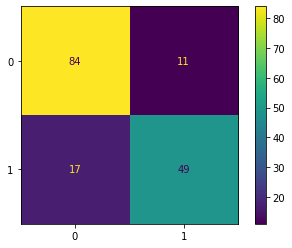

In [204]:
try:
    cm = confusion_matrix(y_orig, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtc)
    disp.plot()
except Exception as e:
    print("")
    #logging.error(traceback.format_exc())

In [205]:
prediction._call_java('rootNode').toString()

'InternalNode(prediction = 0.0, impurity = 0.48197404262137483, split = org.apache.spark.ml.tree.ContinuousSplit@fff80000)'

In [206]:
print(prediction.toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_1cc093b4aedf, depth=5, numNodes=31, numClasses=2, numFeatures=3
  If (feature 2 <= 1.5)
   If (feature 1 <= 15.5)
    If (feature 0 <= 2.5)
     Predict: 1.0
    Else (feature 0 > 2.5)
     If (feature 1 <= 2.5)
      Predict: 0.0
     Else (feature 1 > 2.5)
      If (feature 1 <= 6.5)
       Predict: 1.0
      Else (feature 1 > 6.5)
       Predict: 0.0
   Else (feature 1 > 15.5)
    If (feature 0 <= 1.5)
     If (feature 1 <= 42.5)
      If (feature 1 <= 22.5)
       Predict: 0.0
      Else (feature 1 > 22.5)
       Predict: 1.0
     Else (feature 1 > 42.5)
      Predict: 0.0
    Else (feature 0 > 1.5)
     Predict: 0.0
  Else (feature 2 > 1.5)
   If (feature 0 <= 2.5)
    If (feature 1 <= 2.5)
     If (feature 0 <= 1.5)
      Predict: 0.0
     Else (feature 0 > 1.5)
      Predict: 1.0
    Else (feature 1 > 2.5)
     Predict: 1.0
   Else (feature 0 > 2.5)
    If (feature 1 <= 36.75)
     If (feature 1 <= 31.5)
      If (featu

In [207]:
spark.stop()